# IFU Spectral Extraction

## Introduction

This notebook demonstrates spectral extraction from a [NIRSpec IFU](https://jwst-docs.stsci.edu/near-infrared-spectrograph/nirspec-observing-modes/nirspec-ifu-spectroscopy) datacube:

* Quicklook extraction with [Cubeviz](https://jdaviz.readthedocs.io/en/latest/cubeviz/index.html)
* Retrieving spectra, spatial regions, and spectral regions from Cubeviz
* Aperture extraction in a notebook 
* Optimal extraction in a notebook


## Data
A faint (quasar) point source was simulated using the NIRSpec Instrument Performance Simulator (IPS), then run through the Spec2 stage of the [JWST pipeline](https://jwst-pipeline.readthedocs.io/en/latest/).   

## Imports 

* _numpy_ for array math
* _scipy_ for ndcube gaussian smoothing
* _specutils_ for Spectrum1D data model and cube manipulation
* _jdaviz_ for the Cubeviz data visualization tool
* _jwst_ for JWST data models
* _photutils_ to define circular apertures
* _astropy.io_ for reading and writing FITS cubes and images
* _astropy.wcs, units, coordinates_ for defining and reading WCS
* _astropy.stats_ for sigma_clipping
* _astropy.utils_ for downloading files from URLs
* _astropy.units_ for unit definitions
* _astropy.nddata_ for uncertainty object types
* _matplotlib_ for plotting spectra and images

In [1]:
#Resize notebook to full width
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [2]:
#Add the following to requirements.txt:
#!pip install git+https://github.com/specutils
#!pip install jwst
#!pip install photutils 

import numpy as np
import scipy

import specutils
from specutils import Spectrum1D, SpectralRegion
from specutils.manipulation import extract_region, spectral_slab
from specutils.analysis import moment

from jdaviz import CubeViz

from jwst import transforms

from photutils import CircularAperture, SkyCircularAperture, aperture_photometry
from photutils.detection import DAOStarFinder
from photutils.centroids import centroid_com, centroid_1dg, centroid_2dg, centroid_quadratic

from regions import PixCoord, CirclePixelRegion

from astropy.io import fits
from astropy import wcs
from astropy.stats import sigma_clip
from astropy.stats import sigma_clipped_stats
from astropy.utils.data import download_file
import astropy.units as u
from astropy.nddata import StdDevUncertainty, VarianceUncertainty

%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm


## Simulated NIRSpec IFU Cube

A point source (quasar) was simulated using the NIRSpec Instrument Performance Simulator (IPS), then run through the JWST Spec2 pipeline. We will use this for our science dataset.

In [3]:
#Download the cube data from Box (bright quasar)
#filename = "https://stsci.box.com/shared/static/ff0bj31acot1272x5qq2clbmto3s6v4f.fits"

# NIRSpec IFU science data cube (faint quasar)
BoxPath = "https://data.science.stsci.edu/redirect/JWST/jwst-data_analysis_tools/IFU_optimal_extraction/"
filename = BoxPath + "NRS00001-faintQSO-F100LP-G140H-01_1_491_SE_2020-08-25T12h15m00_s3d.fits"

cube_file = download_file(filename, cache=True)


## Visualize Science Data with Cubeviz

In [4]:
cubeviz = CubeViz()
cubeviz.app

Application(components={'g-viewer-tab': '<template>\n  <component :is="stack.container">\n    <g-viewer-tab\n …

### UI Instructions:
#### Task 1:  Load the cube and view it
* Load science datacube into Cubeviz using the next code cell below
* Click the Display icon in the leftmost image viewer 
* Change the stretch to Logarithmic, 99 percentile to see the target PSF wings.
* Scrub through the cube using the Slice slider.

#### Task 2:  Extract a spectrum from a region (subset) of the cube
* Select a circular subset region centered on the source, using the region selection tool under the Tools icon. 
* Note that the region is pixelated and doesn't include fractional pixels.
* Change the collapse method to "Sum" in spectrum viewer: Display icon: Viewer. 
* Adjust the size and location of the region until you are happy with the extraction that shows up in the spectrum viewer.

#### Task 3: Select a spectral region for further analysis
* In the spectrum viewer, use the vertical and horizontal pan and zoom tools to focus on the broad H-beta line (redshifted to 1.22 microns).  To pan: drag and drop spectrum with mouse or trackpad. To zoom: scroll with mouse or trackpad.
* Select a spectral subset region in spectrum viewer, using the region selection tool under the Tools icon, centered on a spectral feature of interest.


## Load Cube into Cubeviz

*Developer notes:* 
* *Multiple spectral_cube warnings occur when loading the cube into Cubeviz*

In [5]:
#Developer Note--spectral_cube warnings:
cubeviz.app.load_data(cube_file)

## Export Region from Cubeviz
Export the region defined by the user in Cubeviz as an astropy CirclePixel Region, which has units of pixels.  Use "try:, except:" to catch the case where there is no Subset 1 selected in Cubeviz. 

In [6]:
cubeviz_data = cubeviz.app.data_collection[0]
try:
    region1 = cubeviz.app.get_subsets_from_viewer('spectrum-viewer')['Subset 1']
    print(region1)
    region1_exists = True
    center1_xy = [region1.center.x, region1.center.y]  
    r_pix = region1.radius

except Exception:
    print("There are no regions selected in the cube viewer.")
    region1_exists = False
    center1_xy = [17.1, 20.]
    r_pix = 6.0
      

Region: CirclePixelRegion
center: PixCoord(x=17.228483200073242, y=21.677576065063477)
radius: 3.2499375343322754


## Retrieve Subset Spectrum from Cubeviz Spectrum Viewer
Get the spectrum of user-defined Subset1 from the Spectrum Viewer as a Spectrum1D object. Trim to remove bad wavelength ranges.

*Developer notes:* 
* *Can't convert Subset1 Spectrum1D wavelengths from meters to microns.*

In [56]:
# try..except in case there is no Subset1
try:
    spec1d_subset1_untrimmed = cubeviz.app.get_data_from_viewer('spectrum-viewer')['Subset 1']
    print(spec1d_subset1_untrimmed)
    
except Exception:
    print("There are no subsets selected in the spectrum viewer.")
    
#Developer Note--Attribute Error trying to convert to microns
#spec1d_subset1_untrimmed = spec1d_subset1_untrimmed.with_spectral_unit(u.um)


Spectrum1D (length=2059)
flux:             [ 0.017701 MJy / sr, ..., 0.0 MJy / sr ],  mean=0.15301 MJy / sr
spectral axis:    [ 9.6652e-07 m, ..., 1.4502e-06 m ],  mean=1.2083e-06 m


## Extract Spectrum in Expanding Circular Aperture (Cone)
This method is appropriate for a point source PSF with width proportional to wavelength. In the next cell, we read the cube into a Spectrum1D object and perform aperture photometry on each wavelength slice using photutils.

*Developer notes:* 
* *Can't print Spectrum1D read with JWST s3d format. See [specutils issue #868]( https://github.com/astropy/specutils/issues/868).*
* *spectral slab gives warning for Subset1 spectrum: 'No Observer defined on WCS, Spectral Coord'*

  warnings.warn('No observer defined on WCS, SpectralCoord '

2021-09-15 14:17:21,102 - stpipe - WARNING - /Users/pogle/miniconda3/envs/jwebbinar8/lib/python3.9/site-packages/astropy/wcs/wcsapi/fitswcs.py:558: AstropyUserWarning: No observer defined on WCS, SpectralCoord will be converted without any velocity frame change
  warnings.warn('No observer defined on WCS, SpectralCoord '

  warnings.warn('No observer defined on WCS, SpectralCoord '



Max RMS Uncertainty:  0.89693046
Region: CirclePixelRegion
center: PixCoord(x=15.228483200073242, y=16.677576065063477)
radius: 3.2499375343322754
Spectrum1D (length=1916)
flux:             [ 0.083012 MJy / sr, ..., 0.0 MJy / sr ],  mean=0.16193 MJy / sr
spectral axis:    [ 1.0001 um, ..., 1.4502 um ],  mean=1.2251 um


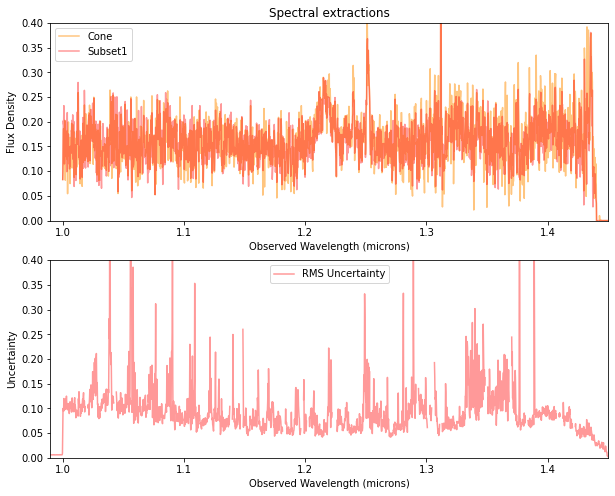

In [68]:
#Load the cube with Spectrum1D    
spec1d_untrimmed = Spectrum1D.read(cube_file, format='JWST s3d')
wavelength_untrimmed = spec1d_untrimmed.spectral_axis.value
err_sum = np.sqrt(np.sum(spec1d_untrimmed.uncertainty.array**2, axis=(0,1)))
print("Max RMS Uncertainty: ", np.amax(np.nan_to_num(errsum)))


#Developer Note--can't print the Spectrum1D.  
#See https://github.com/astropy/specutils/issues/868
#print(spec1d_untrimmed)

# Trim the data cube and Subset1 spectrum
wave_trim =[1.0*u.um,1.88*u.um]
x_trim = [2,-1]
y_trim = [5,-4]
spec1d = spectral_slab(spec1d_untrimmed, wave_trim[0], wave_trim[1])[x_trim[0]:x_trim[1],y_trim[0]:y_trim[1],:]
wavelength = spec1d.spectral_axis
spec1d_len = len(wavelength.value)

# Trim the Subset1 spectrum
#Developer note--"No observer defined on WCS":
spec1d_subset1 = spectral_slab(spec1d_subset1_untrimmed, wave_trim[0], wave_trim[1])
 
#Adjust region location in trimmed cube
center_trim = PixCoord(x=center1_xy[0]-x_trim[0], y=center1_xy[1]-y_trim[0])
center_x = center_trim.x
center_y = center_trim.y
region_trim = CirclePixelRegion(center=center_trim, radius=r_pix)
print(region_trim)

#Use photutils.aperture_photometry to measure flux in expanding or constant aperture
aperture = 'cone'  # 'cone' or 'cylinder'
flux_sum = []
for idx in range(spec1d_len):
    if aperture == 'cone':
        r_cone = r_pix * wavelength.value[idx]/ wavelength.value[0]
    else: r_cone = r_pix  
    aperture_cone = CircularAperture((center_x,center_y), r=r_cone)
    phot_table = aperture_photometry(spec1d.flux.value[:, :, idx], aperture_cone)
    flux_sum.append(phot_table['aperture_sum'][0])
    
cone = Spectrum1D(flux=np.array(flux_sum)*u.MJy/u.sr, spectral_axis=spec1d.spectral_axis)
print(cone)

#Compare conical extraction to Cubeviz pixelated cylindrical extraction
f, (ax1,ax2) = plt.subplots(2, 1, figsize=(10, 8)) 
ax1.set_title("Spectral extractions")
ax1.set_xlabel("Observed Wavelength (microns)")  
ax1.set_ylabel("Flux Density")
ax1.set_xlim(0.99, 1.45)
ax1.set_ylim(0, 0.4)
ax1.plot(wavelength, cone.flux.value, label="Cone", c='darkorange', alpha=0.5)
try:
    ax1.plot(spec1d_subset1.spectral_axis.value*1.0E6, spec1d_subset1.flux.value, c='r', label="Subset1", alpha=0.4)
except Exception:
    print("There is no Cubeviz Subset1 spectrum to plot.")
ax1.legend()

ax2.set_xlabel("Observed Wavelength (microns)")  
ax2.set_ylabel("Uncertainty")
ax2.plot(wave_untrimmed, errsum, c='r', label="RMS Uncertainty", alpha=0.4)
ax2.set_xlim(0.99, 1.45)
ax2.set_ylim(0, 0.4)
ax2.legend()

plt.show()

Top: Comparison of the conical and Cubeviz subset spectral extractions. 
The conical extraction captures slightly more flux at long wavelengths.
Red-shifted Broad Balmer and narrow [O III] lines  are visible in the quasar spectra. 

Bottom: RMS uncertainty, sqrt(sum(sigma^2)), summed over full IFU footprint. 

## WebbPSF Model PSF for Optimal Extraction
Generate PSF model cube using WebbPSF for NIRSpec IFU, or read in precomputed PSF model cube.

Caution! The WebbPSF model takes about 10 hr to run. Uncomment the following cell to do so. Otherwise, read in the precomputed WebbPSF model, which covers the full F100LP/G140H wavelength range (blue and red). For other filter/grating combinations, uncomment and run the cell below using the wavelengths from the science data set.

In [13]:
'''
#WebbPSF imports
%pylab inline
import webbpsf

#WebbPSF commands used to create PSF model cube
ns.image_mask = "IFU"  # Sets to 3x3 arcsec square mask
ns = webbpsf.NIRSpec()
wavelengths = wavelength*1.0E-6
psfcube = ns.calc_datacube(wavelengths, fov_pixels=30, oversample=4,  add_distortion=True)
psfcube.writeto("Webbpsf_ifucube.fits")
'''

'\n#WebbPSF imports\n%pylab inline\nimport webbpsf\n\n#WebbPSF commands used to create PSF model cube\nns.image_mask = "IFU"  # Sets to 3x3 arcsec square mask\nns = webbpsf.NIRSpec()\nwavelengths = wavelength*1.0E-6\npsfcube = ns.calc_datacube(wavelengths, fov_pixels=30, oversample=4,  add_distortion=True)\npsfcube.writeto("Webbpsf_ifucube.fits")\n'

In [14]:
BoxPath = "https://data.science.stsci.edu/redirect/JWST/jwst-data_analysis_tools/IFU_optimal_extraction/"
psf_filename = BoxPath+"Webbpsf_ifucube.fits"

# Load with astropy.fits.open
with fits.open(psf_filename, memmap=False) as hdulist:
    psf_model = hdulist['DET_SAMP'].data
    psf_hdr = hdulist['DET_SAMP'].header
    hdulist.info()    
print(psf_model.shape)


Filename: /Users/pogle/.astropy/cache/download/url/4931b72fec159f8a439e8c80c181370f/contents
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  OVERSAMP      1 PrimaryHDU   105786   (120, 120, 3915)   float64   
  1  DET_SAMP      1 ImageHDU     105788   (30, 30, 3915)   float64   
  2  OVERDIST      1 ImageHDU     105831   (120, 120, 3915)   float64   
  3  DET_DIST      1 ImageHDU     105832   (30, 30, 3915)   float64   
(3915, 30, 30)


## Align Model PSF Cube with Science Data

Find the (x,y) offset between the Model and simulated PSF peaks. Shift and smooth the model PSF cube to align with the simulated data. 

(30, 30, 1916)
(3915, 30, 30)
(15.837711799645442, 14.861482354242469)
(14.600237860899703, 14.456440366253732)
shift =  (1.2374739387457385, 0.4050419879887368)


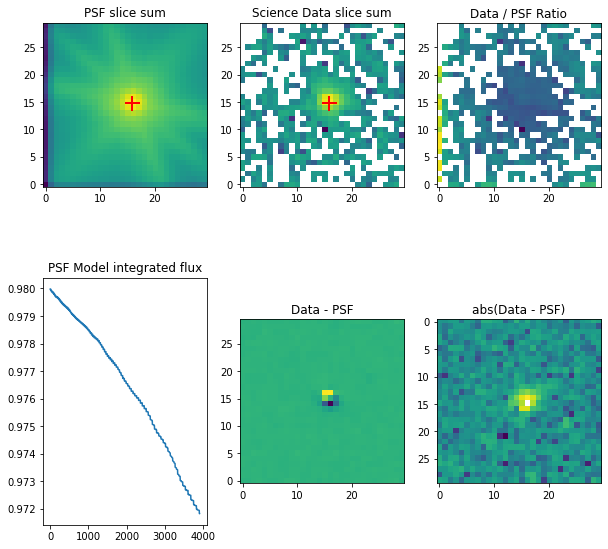

In [15]:
#Compare the shapes of the source and model data cubes
print(np.array(spec1d.flux.value).shape)
print(psf_model.shape)

# Flip model PSF left-right because WebbPSF is flipped with respect to the IPS simulation.
psf_model = psf_model[:, ::-1, :]

#Measure centroids of source and PSF model
#Developer note--centroid_1dg and centroid_2dg give errors here; centroid_quadratic is not robust:
cube_sum = moment(spec1d, order=0)
psf_model_sum = np.sum(psf_model, axis=0)
x1, y1 = centroid_com(cube_sum)
x2, y2 = centroid_com(psf_model_sum)
shiftx = x1 - x2
shifty = y1 - y2
print((x1,y1))
print((x2,y2))
print("shift = ", (shiftx, shifty))

# Shift model PSF using linear interpolation
#The x and y shifts are interchanged, per python indexing convention
psf_model_aligned = scipy.ndimage.shift(psf_model, (0.0, shifty, shiftx), order=1, 
                                        mode='constant', cval=0.0, prefilter=True)
# Smooth model PSF
# EMSM smoothing for G140H grating
scalerad = 0.046  # sigma (arcsec)
pixelscale = 0.1
scalerad_pix = scalerad / pixelscale
psf_model_smoothed = scipy.ndimage.filters.gaussian_filter(psf_model_aligned, 
                                                           (0.0, scalerad_pix, scalerad_pix), 
                                                           order=0, mode='reflect', cval=0.0,  
                                                           truncate=10.0)

# Sum smoothed PSF over wavelength
psf_model_sum = np.sum(psf_model_smoothed, axis=0)

# Scale factor for PSF subtraction
scalefactor = np.amax(cube_sum) / np.amax(psf_model_sum)

# Sum model PSF over spaxels
psf_model_fnusum = np.sum(psf_model, axis=(1, 2))

# Plot the collapsed model and data PSFs
f, ([ax1, ax2, ax3], [ax4, ax5, ax6]) = plt.subplots(2, 3, figsize=(10, 10)) 
ms, mew = 15., 2.
ax1.set_title("PSF slice sum")
ax1.imshow(psf_model_sum,origin = 'lower',norm=LogNorm())
ax1.plot(x1, y1, color='red', marker='+', ms=ms, mew=mew)

ax2.set_title("Science Data slice sum")
ax2.imshow(cube_sum, origin='lower', norm=LogNorm()) 
ax2.plot(x1, y1, color='red', marker='+', ms=ms, mew=mew)

ax3.set_title("Data / PSF Ratio")
ax3.imshow(cube_sum / psf_model_sum, origin='lower', norm=LogNorm())

ax4.set_title("PSF Model integrated flux")
ax4.plot(psf_model_fnusum)

ax5.set_title("Data - PSF")
ax5.imshow(cube_sum - scalefactor * psf_model_sum, origin='lower')

#Developer Note--Unit Conversion Error:
#im6 = ax6.imshow(np.log10(np.absolute(cube_sum - scalefactor * psf_model_sum)))
im6 = ax6.imshow(np.absolute(cube_sum - scalefactor * psf_model_sum), norm=LogNorm())
#plt.colorbar(im6)
ax6.set_title("abs(Data - PSF)")

plt.show()

Top row: Collapsed WebbPSF Model PSF, simulated quasar PSF, and their ratio. The ratio will be used for the optimal extraction below. The red cross symbols show the computed centroids of the two aligned PSFs.

Bottom left: The integrated flux decreases from 98% to 97% of the total model flux over the wavelength range of the dataset.

Bottom center, bottom right : Difference and absolute value of difference between the aligned science data and model PSFs.

## Optimal Extraction using WebbPSF Model

Optimal extraction ([Horne 1986, PASP, 98, 609](https://ui.adsabs.harvard.edu/abs/1986PASP...98..609H/abstract)) weights the flux contributions to a spectrum by their signal-to-noise ratio (SNR). Dividing the simulated data by the model PSF gives an estimate of the total flux density spectrum in each spaxel. A weighted average of these estimates over all spaxels yields the optimally extracted spectrum over the cube. In the faint source limit, where the noise is background-dominated, optimal extraction inside a 3-sigma radius can increase the effective exposure time by a factor of 1.69 (Horne et al. 1986). In the bright source limit, where the noise is dominated by the Poisson statistics of the source, optimal extraction is formally identical to a straight sum over spaxels for a perfect PSF model.
We use the WebbPSF PSF model for this first attempt at optimal extraction.


In [16]:
## List of cube slices for extraction
data = []
var = []

for idx in range(spec1d_len): 
    data.append(spec1d.data[:, :, idx])
    sigma = spec1d.uncertainty.array[:,:,idx]
    #var.append(sigma**2)
    var.append(sigma)
    #Use var = sigma, not sigma**2, which gives noisy results
data = np.array(data)
var = np.array(var)


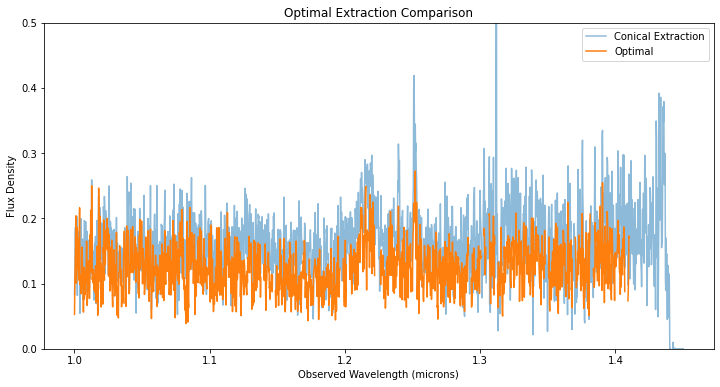

In [17]:
# Window PSF model (and replace NaNs)
profile = np.nan_to_num(psf_model_smoothed[0:1916, :, :]) 

# Divide data by PSF model
data_norm = np.nan_to_num(data / profile)

# Mask out bad data using 3-sigma clipping in each slice
data_norm_clipped = sigma_clip(data_norm, sigma=3.0, maxiters=5, axis=(1, 2))
badvoxel = np.where(data_norm_clipped == 0)
data_clean = 1.0 * data
data_clean[badvoxel] = 0.0

# Optimal extraction, using model profile weight and variance cube from the simulated data
optimal_weight = profile ** 2 / var
optimal_weight_norm = np.sum(optimal_weight, axis=(1, 2))
spectrum_optimal = np.sum(profile * data_clean / var, axis=(1, 2)) / optimal_weight_norm

# Plots
f, (ax1) = plt.subplots(1, 1, figsize=(12, 6)) 
ax1.set_title("Optimal Extraction Comparison")
ax1.set_xlabel("Observed Wavelength (microns)") 
ax1.set_ylabel("Flux Density")
ax1.set_ylim(0, 0.5)
ax1.plot(wavelength, cone.flux.value, label="Conical Extraction", alpha=0.5)
ax1.plot(wavelength, spectrum_optimal, label="Optimal")
ax1.legend()

plt.show()


(1916, 30, 30)
(1916, 30, 30)
(1916, 30, 30)
(30, 30)


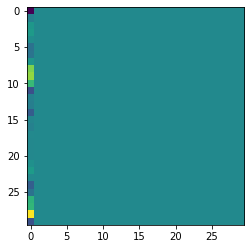

In [92]:
#Sandbox
spec1d_sum = spec1d + spec1d
print(np.transpose(spec1d.flux.value).shape)
print(psf_model_smoothed[0:1916, :, :].shape)
ratio = np.transpose(spec1d.flux.value)/psf_model_smoothed[0:1916, :, :]
print(ratio.shape)
ratio_sum = np.sum(ratio, axis=0)
print(ratio_sum.shape)
plt.imshow(ratio_sum)

#plt.plot(spec1d.spectral_axis, np.sum(spec1d.flux.value,axis=(0,1)))
#plt.ylim(-1,2)
#plt.show()
#plt.plot(spec1d_sum.spectral_axis, np.sum(spec1d_sum.flux.value,axis=(0,1)))
#plt.ylim(-1,2)
#plt.show()

<img style="float: right;" src="https://raw.githubusercontent.com/spacetelescope/notebooks/master/assets/stsci_pri_combo_mark_horizonal_white_bkgd.png" alt="Space Telescope Logo" width="200px"/>

Notebook created by Patrick Ogle.